In [9]:
import pandas as pd
from tqdm import tqdm

df = pd.read_excel("preprocessed.xlsx")
columns_ignore = ['name', 'released', 'score', 'votes', 'gross', 'same_year']

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=1, interaction_only=True, include_bias=False)

X = df.drop(
    columns_ignore,
    axis=1,
)
X = poly.fit_transform(X)
y = df["score"]

X, X_test_final, y, y_test_final = train_test_split(X, y, test_size=0.2, random_state=42)

# Models

In [11]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt


def plot_predictions(y_test, y_pred):
    plt.scatter(y_test, y_pred, color="blue")
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title("Predictions vs. Truth")
    plt.show()


def evaluate(model, X, y):
    pred = model.predict(X)
    print("Mean squared error: %.2f" % mean_squared_error(y, pred))
    print("Mean absolute error: %.2f" % mean_absolute_error(y, pred))
    print("Coefficient of determination: %.2f" % r2_score(y, pred))
    plot_predictions(y, pred)

In [12]:
models = []

## LinearRegression

In [13]:
from sklearn.linear_model import LinearRegression

for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    linear_regressor = LinearRegression()
    linear_regressor = linear_regressor.fit(X_train, y_train)

    models.append((f"linreg{i}", linear_regressor))

Mean squared error: 0.61
Mean absolute error: 0.60
Coefficient of determination: 0.34


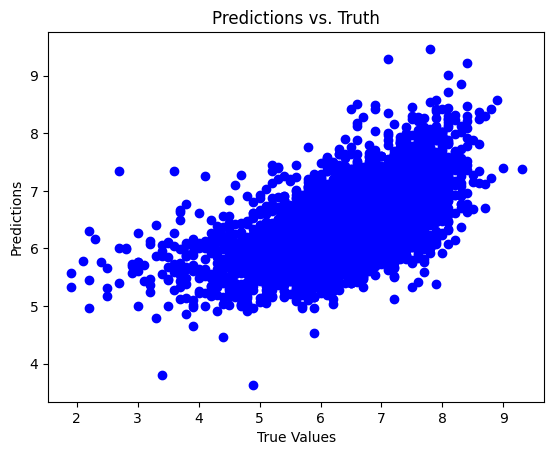

Mean squared error: 0.64
Mean absolute error: 0.61
Coefficient of determination: 0.33


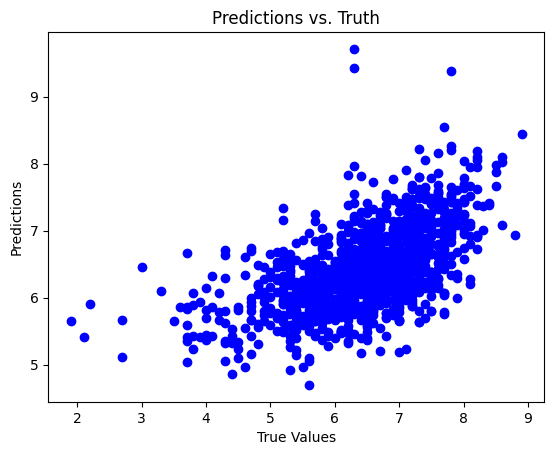

In [14]:
evaluate(linear_regressor, X_train, y_train)
evaluate(linear_regressor, X_test, y_test)

## DecisionTree

In [17]:
from sklearn.tree import DecisionTreeRegressor

for max_leaf_nodes in tqdm(range(1, 10)):
    for max_depth in range(1, 10):
        for criterion in ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
            decision_tree = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes**2, max_depth=max_depth**2, criterion=criterion)
            decision_tree = decision_tree.fit(X_train, y_train)

            models.append((f"dt{max_leaf_nodes},{max_depth},{criterion}", decision_tree))
    
decision_tree = DecisionTreeRegressor(max_depth=6)
decision_tree = decision_tree.fit(X_train, y_train)

Mean squared error: 0.63
Mean absolute error: 0.61
Coefficient of determination: 0.32


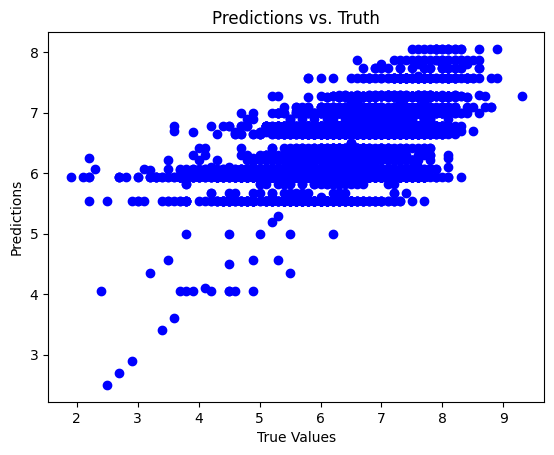

Mean squared error: 0.75
Mean absolute error: 0.65
Coefficient of determination: 0.20


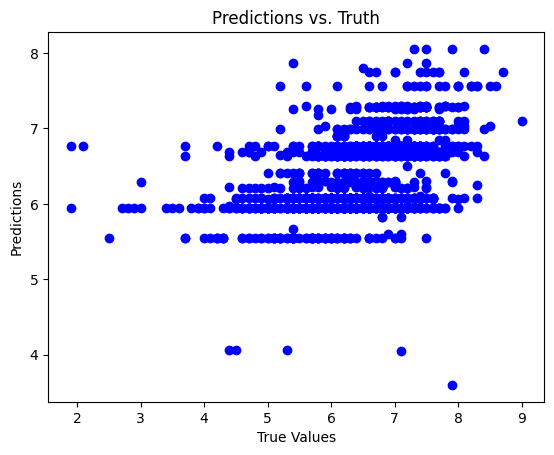

In [18]:
evaluate(decision_tree, X_train, y_train)
evaluate(decision_tree, X_test, y_test)

## Forest Regressor

In [19]:
from sklearn.ensemble import RandomForestRegressor
import random

n_iters = 0

hyperparameters = set()
for max_depth in random.sample(range(1, 11), 3):
    # n_estimators
    for n_estimators in random.sample(range(50, 500), 10):
        # max_features
        for max_features in random.sample(range(1, 11), 3):
            # min_samples_split
            for min_samples_split in random.sample(range(2, 11), 3):
                # min_samples_leaf
                for min_samples_leaf in random.sample(range(1, 11), 3):
                    hyperparameters.add((max_depth, n_estimators, max_features, min_samples_split, min_samples_leaf))

for i in range(3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    forest = RandomForestRegressor()
    forest = forest.fit(X_train, y_train)

    for max_depth, n_estimators, max_features, min_samples_split, min_samples_leaf in tqdm(hyperparameters):
        forest = RandomForestRegressor(
            max_depth=max_depth*2,
            n_estimators=n_estimators,
            max_features=max_features*3,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
        )
        forest = forest.fit(X_train, y_train)
        n_iters += 1
        models.append((f"forest{n_iters}", forest))

for i in n_iters(range(10)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    forest = RandomForestRegressor()
    forest = forest.fit(X_train, y_train)
    n_iters += 1
    models.append((f"forest{n_iters}", forest))

  9%|▊         | 69/810 [01:27<15:50,  1.28s/it]

In [ ]:
evaluate(forest, X_train, y_train)
evaluate(forest, X_test, y_test)

## Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

for lr in tqdm(range(10)):
    for loss in ['squared_error', 'absolute_error', 'huber', 'quantile']:
        for criterion in ['friedman_mse', 'squared_error']:
            for n_estimators in (range(1, 10)):
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
                
                gradient_boosting = GradientBoostingRegressor(learning_rate= 10**-lr, criterion=criterion, loss=loss, n_estimators=n_estimators**2)
                gradient_boosting = gradient_boosting.fit(X_train, y_train)

                models.append((f"gradient_boosting{lr}, {criterion}, {loss}, {n_estimators}", gradient_boosting))

100%|██████████| 9/9 [00:01<00:00,  6.46it/s]


In [ ]:
evaluate(gradient_boosting, X_train, y_train)
evaluate(gradient_boosting, X_test, y_test)

In [ ]:
from sklearn.neural_network import MLPRegressor

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    mlp = MLPRegressor(hidden_layer_sizes=64, activation='logistic', solver='sgd', alpha=0, batch_size=1, learning_rate_init=.01, shuffle=True, momentum=0, n_iter_no_change=50, max_iter=250)
    mlp = mlp.fit(X_train, y_train)

    models.append((f"mlp{i}", mlp))

In [ ]:
evaluate(mlp, X_train, y_train)
evaluate(mlp, X_test, y_test)

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

hyperparameters = set()
for n_neighbors in range(1, 11):
    for weights in ['uniform', 'distance']:
        for algorithm in ['auto', 'ball_tree', 'kd_tree', 'brute']:
            for leaf_size in range(1, 11):
                for p in range(1, 11):
                    hyperparameters.add((n_neighbors, weights, algorithm, leaf_size, p))

n_iters = 0

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    knn = KNeighborsRegressor()
    knn = knn.fit(X_train, y_train)

    n_iters += 1
    models.append((f"knn{n_iters}", knn))

for n_neighbors, weights, algorithm, leaf_size, p in tqdm(hyperparameters):
    knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm, leaf_size=leaf_size, p=p)
    knn = knn.fit(X_train, y_train)
    n_iters += 1
    models.append((f"knn{n_iters}", knn))

100%|██████████| 8000/8000 [02:57<00:00, 45.13it/s]


In [ ]:
evaluate(knn, X_train, y_train)
evaluate(knn, X_test, y_test)

## Clustering

In [ ]:
from sklearn.cluster import KMeans

hyperparameters = set()
for n_clusters in range(1, 11):
    for init in ['k-means++', 'random']:
        for n_init in range(1, 11):
            for max_iter in range(1, 11):
                for tol in range(1, 11):
                    hyperparameters.add((n_clusters, init, n_init, max_iter, tol))

n_iters = 0

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    kmeans = KMeans()
    kmeans = kmeans.fit(X_train)

    n_iters += 1
    models.append((f"kmeans{n_iters}", kmeans))

for n_clusters, init, n_init, max_iter, tol in tqdm(hyperparameters):
    kmeans = KMeans(n_clusters=n_clusters, init=init, n_init=n_init, max_iter=max_iter, tol=tol)
    kmeans = kmeans.fit(X_train)
    n_iters += 1
    models.append((f"kmeans{n_iters}", kmeans))

In [ ]:
evaluate(kmeans, X_train, y_train)
evaluate(kmeans, X_test, y_test)

# Ensemble

### Voting Regressor

In [ ]:
# Ensemble
from sklearn.ensemble import VotingRegressor

def weight(model):
    return 1/mean_squared_error(model.predict(X_test), y_test)

ereg = VotingRegressor(estimators=[('knn', knn), ('rf', forest), ('gb', gradient_boosting), ('lr', linear_regressor) #, ('mlp', mlp)
                                   ], weights=[weight(knn), weight(forest), weight(gradient_boosting), weight(linear_regressor)
                                               #, weight(mlp)
                                               ])
ereg = ereg.fit(X_train, y_train)

In [ ]:
evaluate(ereg, X_train, y_train)
evaluate(ereg, X_test, y_test)

### Stacking 

In [ ]:
# Ensemble
from sklearn.ensemble import StackingRegressor

stack = StackingRegressor(estimators=models, final_estimator=LinearRegression())
stack = stack.fit(X_train, y_train)

: 

In [ ]:
evaluate(stack, X_train, y_train)
evaluate(stack, X_test, y_test)